## Imports

In [24]:
import numpy as np
import pandas as pd
import datetime
import math
import random
import sys

pd.options.display.max_columns = 50

In [2]:
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [61]:
# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set(color_codes=True)

In [3]:
import pprint
from collections import defaultdict
from gensim import corpora, models, similarities
# NLTK Stop words
from nltk.corpus import stopwords


## Functions

In [48]:
def set_labels(freq, ax,horz_shift=.2,vert_shift=1000,w="bold",fsize=10,c="b"):
    '''
    Function
    --------
    Set Frequency Labels on Bar Plot
    
    Parameters
    ----------
    freq : List of frequencies to plot for each bar
    ax : Axis to Plot Frequency Labels on
    horz_shift : Shift labels left/right
    vert_shift : Shift labels up/down
    w : "weight" -> Bold by defauly
    fsize : fontsize
    c : label color
    
    '''
    for i, v in enumerate(freq):
        ax.text(i-horz_shift,v+vert_shift, str(round(v,2)), weight = w,fontsize=fsize,color = c)

In [4]:
def process_corpus(text_corpus):
    '''
    '''
    # Create a set of frequent words
#     stoplist = ""
#     stoplist = set('for a of the and to in is our with we that by their through as\
#                    are mission on'.split(' '))
    
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_',
                   'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 
                   'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 
                   'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
    
    
    # Lowercase each document, split it by white space and filter out stopwords
    texts = ""
    texts = [[word for word in document.lower().split() if word not in stop_words] for document in text_corpus]
    
    # Count word frequencies
    frequency = defaultdict(int)
    
    for text in texts:
        for token in text:
            frequency[token] += 1
    
    words_df = pd.DataFrame(list(frequency.items()), columns= ['Words','count']).sort_values('count',ascending=False)
    
    ten_percent_cutoff = (int(len(text_corpus)*0.1))
            
    # Only keep words that appear more than once, are in less than 10% of documents, and are alphabetical strings
    processed_corpus = []
    
    for text in texts:
        token_list = []
        for token in text:
            if frequency[token] > 1 and frequency[token] < ten_percent_cutoff and str.isalpha(token):
                token_list.append(token)
        processed_corpus.append(token_list)
    
    return processed_corpus

In [5]:
def create_index_from_corpus(processed_corpus):
    '''
    '''
    dictionary = corpora.Dictionary(processed_corpus)
    features = (len(dictionary))
    
    bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
    
    # train the model
    tfidf = models.TfidfModel(bow_corpus)
    
    index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=features)
    
    return index, dictionary, tfidf

In [6]:
def find_similar_charities(train_df,test_df):
    '''
    '''
    total = 0
    category_counter = {1:0,2:0,3:0}
    document_min_words_cutoff = 200
    
    print("1. Processing Training Corpus")
    char_desc_trimmed = []
    for doc in train_df['description']:
        if len(doc) >= document_min_words_cutoff:
            char_desc_trimmed.append(doc)
    
    char_desc_trimmed = np.array(char_desc_trimmed)
    
    corpus = char_desc_trimmed
    processed_corpus = process_corpus(corpus)
    
    print("2. Creating Index from Training Corpus")
    index, dictionary, tfidf = create_index_from_corpus(processed_corpus)
    
    print("3. Starting Test Corpus Similarity Analysis\n")
    for ind, document in enumerate(test_df['description']):
        total +=1 
        if total % 500 == 0:
            print("Analyzed",total,"documents...")
        #print("Top 3 Charities Similar to:", test_df['name'].iloc[ind],'\n')
        
        query_bow = dictionary.doc2bow(document.split())
        sims = index[tfidf[query_bow]]
        
        top_3_sim = dict()
        count = 3
        
        for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True):
            if count > 0:
                top_3_sim[document_number] = score
            count -= 1
            
        category_count = 1
        
        for doc, score in top_3_sim.items():
            
            if train_df['category'].iloc[doc] == test_df['category'].iloc[ind]:
                category_counter[category_count] += 1
            category_count +=1
            
    # Print Scores
    
    first_rec_score = round((category_counter[1] / total)*100,2)
    second_rec_score = round((category_counter[2] / total)*100,2)
    third_rec_score = round((category_counter[3] / total)*100,2)
    
    print ("\nFirst Recommendation Score:", first_rec_score,"%")
    print ("Second Recommendation Score:", second_rec_score,"%")   
    print ("Third Recommendation Score:", third_rec_score,"%\n")
    
    print ("AVG Recommendation Score:", round((first_rec_score+second_rec_score+third_rec_score)/3,2),"%")
    
    pass
    

In [7]:
def find_similar_charities_all(train_df,test_df):
    '''
    '''
    total = 0
    category_counter = {1:0,2:0,3:0}
    document_min_words_cutoff = 200
    
    
    print("1. Processing Training Corpus")
    char_desc_trimmed = []
    for doc in train_df['description']:
        if len(doc) >= document_min_words_cutoff:
            char_desc_trimmed.append(doc)
    char_desc_trimmed = np.array(char_desc_trimmed)
    
    corpus = char_desc_trimmed
    processed_corpus = process_corpus(corpus)
    
    print("2. Creating Index from Training Corpus")
    index, dictionary, tfidf = create_index_from_corpus(processed_corpus)
    
    print("3. Starting Test Corpus Similarity Analysis\n")
    for ind, document in enumerate(test_df['description']):
        
        total +=1 
        
        if total % 500 == 0:
            print("Analyzed",total,"documents...")
        
        print(document.lower())
        
        query_bow = dictionary.doc2bow(document.lower().split())
        sims = index[tfidf[query_bow]]
        
        top_3_sim = dict()
        count = 3
        
        print(sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[:4])
        
        for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[:4]:
            
            if count > 0:
                top_3_sim[document_number] = score
            count -= 1
            
        category_count = 1
        
        for doc, score in top_3_sim.items():
            print(train_df['name'][doc])
            print(train_df['description'][doc])
            print(doc, score, "\n")
            
            # print (charity_navigator_df['category'][doc])
            # print (test_df['category'].iloc[ind])
            
            
            if train_df['category'][doc] == test_df['category'].iloc[ind]:
                category_counter[category_count] += 1
            category_count +=1
            
    # Print Scores
    
    first_rec_score = round((category_counter[1] / total)*100,2)
    second_rec_score = round((category_counter[2] / total)*100,2)
    third_rec_score = round((category_counter[3] / total)*100,2)
    
    print ("\nFirst Recommendation Score:", first_rec_score,"%")
    print ("Second Recommendation Score:", second_rec_score,"%")   
    print ("Third Recommendation Score:", third_rec_score,"%\n")
    
    print ("AVG Recommendation Score:", round((first_rec_score+second_rec_score+third_rec_score)/3,2),"%")
    
    pass
    

In [116]:
def find_similar_charities_combined(train_df,test_df):
    '''
    '''
    total = 0
    category_counter = {1:0,2:0,3:0}
    document_min_words_cutoff = 200
    
    print("1. Processing Training Corpus")
#     char_desc_trimmed = []
    
#     for doc in train_df['corpus']:
#         if len(doc) >= document_min_words_cutoff:
#             char_desc_trimmed.append(doc)
    
    char_desc_trimmed = np.array(train_df['corpus'])
    
    corpus = char_desc_trimmed
    processed_corpus = process_corpus(corpus)
    
    print("2. Creating Index from Training Corpus")
    index, dictionary, tfidf = create_index_from_corpus(processed_corpus)
    
    print("3. Starting Test Corpus Similarity Analysis\n")
    for ind, document in enumerate(test_df['corpus']):
        total +=1 
        if total % 500 == 0:
            print("Analyzed",total,"documents...")
        
        
        query_bow = dictionary.doc2bow(document.split())
        sims = index[tfidf[query_bow]]
        
        top_3_sim = dict()
        count = 3
        
        for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[1:4]:
            
            if count > 0:
                top_3_sim[document_number] = score
            count -= 1
            
        category_count = 1
        
#         print("Top 3 Charities Similar to:\nName:", test_df['name'].iloc[ind])
#         print('Category:', test_df['category'].iloc[ind],'\n')
        
        for doc, score in top_3_sim.items():
#             print("Name:",train_df['name'].iloc[doc])
#             print("Category:", train_df['category'].iloc[doc])
#             print("Score:",score)
            
            if train_df['category'].iloc[doc] == test_df['category'].iloc[ind]:
                category_counter[category_count] += 1
            category_count +=1
#         print("")
            
    # Print Scores
    
    first_rec_score = round((category_counter[1] / total)*100,2)
    second_rec_score = round((category_counter[2] / total)*100,2)
    third_rec_score = round((category_counter[3] / total)*100,2)
    
    print ("\nFirst Recommendation Score:", first_rec_score,"%")
    print ("Second Recommendation Score:", second_rec_score,"%")   
    print ("Third Recommendation Score:", third_rec_score,"%\n")
    
    print ("AVG Recommendation Score:", round((first_rec_score+second_rec_score+third_rec_score)/3,2),"%")
    
    return top_3_sim
    

## Loading Charity Navigator Data

In [9]:
charity_navigator_df = pd.read_csv('../data/CLEAN_charity_data.csv')
charity_navigator_df = charity_navigator_df[['name','ein','category','description','motto','score','state']]
charity_navigator_df['ein'] = charity_navigator_df['ein'].apply(lambda x: int(x.replace("-","")))

In [47]:
charity_navigator_df.head()

,name,ein,category,description,motto,score,state
0,1000 Friends of Oregon,930642086,Environment,Working with Oregonians to enhance our quality...,Great communities. Working lands. Iconic Places.,91.94,OR
1,WYPR,311770828,"Arts, Culture, Humanities",Serving the metropolitan Baltimore area and th...,88.1 FM -. Your NPR News Station,85.59,MD
2,VSS Catholic Communications,911857425,Religion,VSS Catholic Communications is dedicated to an...,Spirit Catholic Radio Network,76.80,NE
3,Utah Symphony & Opera,510145980,"Arts, Culture, Humanities",The mission of the Utah Symphony & Opera is to...,"Engaging, educating, and enriching lives",91.95,UT
4,Two Ten Footwear Foundation,222579809,Human Services,"Funded solely by the footwear industry, Two Te...",Shoepeople Helping Shoepeople,90.26,MA


In [45]:
charity_navigator_df.groupby('category').size().sort_values(ascending=False)

category
Human Services                2379
Arts, Culture, Humanities     1218
Health                         847
Community Development          803
Education                      667
International                  610
Animals                        454
Religion                       450
Environment                    429
Human and Civil Rights         346
Research and Public Policy     205
dtype: int64

In [59]:
charity_navigator_df['description'][0]

'Working with Oregonians to enhance our quality of life by building livable urban and rural communities, protecting family farms and forests, and conserving natural areas.'

In [94]:
char_desc_lengths = []
for i in charity_navigator_df['description']:
    char_desc_lengths.append(len(i))
char_desc_lengths = np.array(char_desc_lengths)

In [104]:
np.median(char_desc_lengths)

623.0

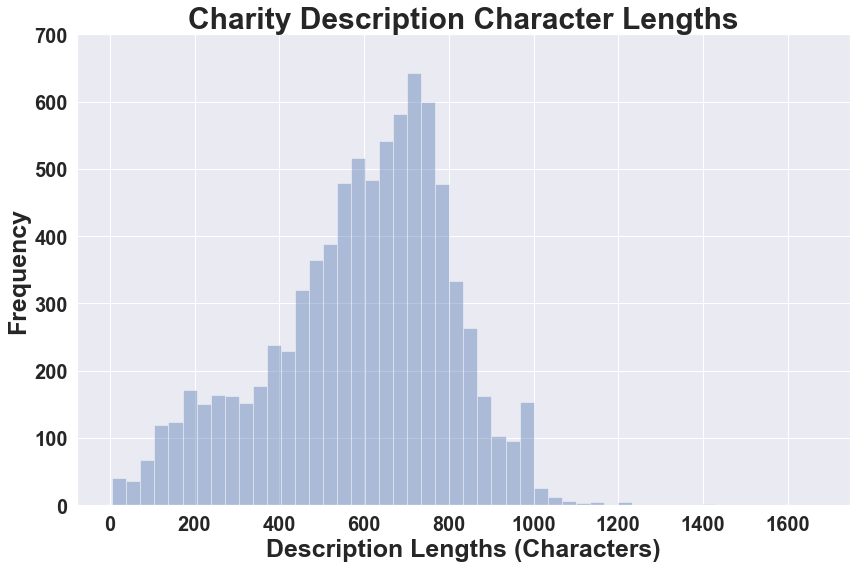

In [101]:
fig, ax = plt.subplots(figsize=(12,8))

ax = sns.distplot(char_desc_lengths,color = 'b',kde=False,hist=True,norm_hist=False)

# Title
ax.set_title(label="Charity Description Character Lengths",weight='bold',fontsize=30)

# X-axis
x_tick_nums = np.arange(0,1601,200)
ax.set_xticks(x_tick_nums)
ax.set_xticklabels(labels=x_tick_nums,weight='bold',fontsize=20)
ax.set_xlabel(xlabel="Description Lengths (Characters)",weight='bold',fontsize=25)

# Y-axis
y_tick_nums = np.arange(0,701,100)
ax.set_yticks(y_tick_nums)
ax.set_yticklabels(labels=y_tick_nums,weight='bold',fontsize=20)
ax.set_ylabel(ylabel="Frequency",weight='bold',fontsize=25)

plt.tight_layout()

# plt.savefig('CharityDescCharacterLengths.png')

In [10]:
# There are 11 Categories Total
## A "Random Guess" Baseline is 1/11 = 9.09%

## Modeling

In [11]:
train_df = charity_navigator_df[:6000]
char_desc_trimmed = []
for doc in train_df['description']:
    if len(doc) >= 200:
        char_desc_trimmed.append(doc)
char_desc_trimmed = np.array(char_desc_trimmed)

In [12]:
len(char_desc_trimmed)

5616

### Sequential Train/Test Split

#### Best Scores:

1. 17.23%
2. 16.07%
3. 16.03%

#### Total = 16.44%

In [239]:
train_df = charity_navigator_df[:6000]
test_df = charity_navigator_df[6000:]

find_similar_charities(train_df,test_df)

1. Processing Training Corpus
2. Creating Index from Training Corpus
3. Starting Test Corpus Similarity Analysis

Analyzed 500 documents...
Analyzed 1000 documents...
Analyzed 1500 documents...
Analyzed 2000 documents...

First Recommendation Score: 14.78 %
Second Recommendation Score: 16.78 %
Third Recommendation Score: 16.9 %

AVG Recommendation Score: 16.15 %


### Random Train/Test Split (Test Size = 30%)

#### Best Scores:

1. 14.70%
2. 14.15%
3. 15.74%

#### Total = 14.86%

In [230]:
test_df['category'].iloc[1695]

'Education'

In [234]:
train_df, test_df = train_test_split(charity_navigator_df,test_size = 0.30)

find_similar_charities(train_df,test_df)

1. Processing Training Corpus
2. Creating Index from Training Corpus
3. Starting Test Corpus Similarity Analysis

Analyzed 500 documents...
Analyzed 1000 documents...
Analyzed 1500 documents...
Analyzed 2000 documents...
Analyzed 2500 documents...

First Recommendation Score: 14.51 %
Second Recommendation Score: 14.15 %
Third Recommendation Score: 14.15 %

AVG Recommendation Score: 14.27 %


### Random Train/Test Split (Test Size = 25%)

#### Best Scores:

1. 14.37%
2. 14.13%
3. 14.84%

#### Total = 14.45%

In [236]:
train_df, test_df = train_test_split(charity_navigator_df,test_size = 0.25)

find_similar_charities(train_df,test_df)

1. Processing Training Corpus
2. Creating Index from Training Corpus
3. Starting Test Corpus Similarity Analysis

Analyzed 500 documents...
Analyzed 1000 documents...
Analyzed 1500 documents...
Analyzed 2000 documents...

First Recommendation Score: 14.22 %
Second Recommendation Score: 15.46 %
Third Recommendation Score: 15.22 %

AVG Recommendation Score: 14.97 %


### Random Train/Test Split (Test Size = 20%)

#### Best Scores:

1. 14.09%
2. 15.40%
3. 12.78%

#### Total = 14.09%

In [237]:
train_df, test_df = train_test_split(charity_navigator_df,test_size = 0.20)

find_similar_charities(train_df,test_df)

1. Processing Training Corpus
2. Creating Index from Training Corpus
3. Starting Test Corpus Similarity Analysis

Analyzed 500 documents...
Analyzed 1000 documents...
Analyzed 1500 documents...

First Recommendation Score: 15.87 %
Second Recommendation Score: 17.0 %
Third Recommendation Score: 14.33 %

AVG Recommendation Score: 15.73 %


### Train on full data set, test on individual charities

#### Best Scores:

1. 14.09%
2. 15.40%
3. 12.78%

#### Total = 14.09%

In [75]:
find_similar_charities(charity_navigator_df,charity_navigator_df.loc[19:50])

1. Processing Training Corpus
2. Creating Index from Training Corpus
3. Starting Test Corpus Similarity Analysis


First Recommendation Score: 12.5 %
Second Recommendation Score: 21.88 %
Third Recommendation Score: 9.38 %

AVG Recommendation Score: 14.59 %


In [81]:
print(len(charity_navigator_df))

charity_navigator_df.iloc[[19,30]]

8408


,name,ein,category,description,motto,score,state
19,Zoo Miami Foundation,596192814,Animals,Zoo Miami Foundation (ZMF) is the non-profit s...,Our mission is to foster community pride and i...,93.74,FL
30,Issaquah Schools Foundation,943050254,Education,"Founded in 1987, in cooperation with the Issaq...",Helping students succeed,86.14,WA


In [270]:
charity_navigator_df.iloc[[70]]['category']

70    Animals
Name: category, dtype: object

In [ ]:
find_similar_charities_all(charity_navigator_df, charity_navigator_df.iloc[[100]])

In [353]:
temp_df = charity_navigator_df.copy()

In [363]:
temp_df['motto'] = temp_df['motto'].fillna(" ")

In [364]:
temp_df.isna().sum()

name           0
ein            0
category       0
description    0
motto          0
score          0
state          0
corpus         0
dtype: int64

In [ ]:
temp_df

In [365]:
temp_df['corpus'] = (temp_df['category'] + " " + temp_df['description'] + " " +temp_df['motto']+" "+ temp_df['state'])

In [393]:
# temp_df.to_csv('../data/charities_rated_corpus.csv')

In [105]:
train_df, test_df = train_test_split(temp_df,test_size = 0.20)

find_similar_charities_combined(train_df,test_df)

NameError: name 'temp_df' is not defined

In [402]:
top_3_sim = find_similar_charities_combined(temp_df,temp_df[temp_df['name']=='National Wildlife Federation'])

1. Processing Training Corpus
2. Creating Index from Training Corpus
3. Starting Test Corpus Similarity Analysis

Top 3 Charities Similar to:
Name: National Wildlife Federation
Category: Animals 

Name: Wildlife Center of Virginia
Category: Animals
Score: 0.4614803
Name: Zoo Atlanta
Category: Animals
Score: 0.4182947
Name: Audubon Society of Portland
Category: Environment
Score: 0.39689428


First Recommendation Score: 100.0 %
Second Recommendation Score: 100.0 %
Third Recommendation Score: 0.0 %

AVG Recommendation Score: 66.67 %


In [403]:
top_3_sim

{4357: 0.4614803, 20: 0.4182947, 4535: 0.39689428}

In [416]:
file_info = temp_df.iloc[2357:2358]

In [423]:
file_info.name.iloc[0]

'Pet Helpers'

In [400]:
temp_df[temp_df['name']=='National Wildlife Federation']

,name,ein,category,description,motto,score,state,corpus
1698,National Wildlife Federation,530204616,Animals,National Wildlife Federation's (NWF) mission i...,Inspiring Americans to protect wildlife for ou...,81.19,VA,Animals National Wildlife Federation's (NWF) m...


In [ ]:
National Wildlife Federation

In [109]:
temp_df2 = pd.read_csv('../data/charities_rated_corpus.csv')
temp_df2.drop(columns=['Unnamed: 0'],inplace=True)

In [110]:
temp_df2

,name,ein,category,description,motto,score,state,corpus
0,1000 Friends of Oregon,930642086,Environment,Working with Oregonians to enhance our quality...,Great communities. Working lands. Iconic Places.,91.94,OR,Environment Working with Oregonians to enhance...
1,WYPR,311770828,"Arts, Culture, Humanities",Serving the metropolitan Baltimore area and th...,88.1 FM -. Your NPR News Station,85.59,MD,"Arts, Culture, Humanities Serving the metropol..."
2,VSS Catholic Communications,911857425,Religion,VSS Catholic Communications is dedicated to an...,Spirit Catholic Radio Network,76.80,NE,Religion VSS Catholic Communications is dedica...
3,Utah Symphony & Opera,510145980,"Arts, Culture, Humanities",The mission of the Utah Symphony & Opera is to...,"Engaging, educating, and enriching lives",91.95,UT,"Arts, Culture, Humanities The mission of the U..."
4,Two Ten Footwear Foundation,222579809,Human Services,"Funded solely by the footwear industry, Two Te...",Shoepeople Helping Shoepeople,90.26,MA,Human Services Funded solely by the footwear i...
...,...,...,...,...,...,...,...,...
8403,Yaddo,141343055,"Arts, Culture, Humanities","Founded in 1900, Yaddo is an artists' communit...",Nurturing the creative process,79.36,NY,"Arts, Culture, Humanities Founded in 1900, Yad..."
8404,Yad L'Achim Peyle Israel,237126417,Religion,Yad L'Achim was established in 1950. It is a n...,Promoting the adherence to Orthodox Jewish obs...,59.84,NY,Religion Yad L'Achim was established in 1950. ...
8405,Yad Ezra,382904733,Human Services,Yad Ezra opened its doors in 1990 with the pur...,Feeding the Jewish hungry,88.07,MI,Human Services Yad Ezra opened its doors in 19...
8406,Rawhide,391052471,Human Services,"Rawhide, where commitment and compassion meet....",Dedicated to helping at-risk youth and their f...,96.91,WI,"Human Services Rawhide, where commitment and c..."


In [117]:
top_3_sim = find_similar_charities_combined(temp_df2,temp_df2)

1. Processing Training Corpus
2. Creating Index from Training Corpus
3. Starting Test Corpus Similarity Analysis

Analyzed 500 documents...
Analyzed 1000 documents...
Analyzed 1500 documents...
Analyzed 2000 documents...
Analyzed 2500 documents...
Analyzed 3000 documents...
Analyzed 3500 documents...
Analyzed 4000 documents...
Analyzed 4500 documents...
Analyzed 5000 documents...
Analyzed 5500 documents...
Analyzed 6000 documents...
Analyzed 6500 documents...
Analyzed 7000 documents...
Analyzed 7500 documents...
Analyzed 8000 documents...

First Recommendation Score: 66.2 %
Second Recommendation Score: 63.59 %
Third Recommendation Score: 63.31 %

AVG Recommendation Score: 64.37 %
